# Collaborative Filtering with Graph Neural Networks

(Credit: This Notebook is heavily based on the work of Prof. A. Ribeiro (ESE, Penn). If you want to learn more about GNNs, I suggest you take Prof. Ribeiro's class entitled "Graph Neural Networks".)

The objective of this lab is to design a recommendation system that predicts the ratings that customers would give to a certain product. Say, the rating that a moviegoer would give to a specific movie, or the rating that an online shopper would give to a particular offering. To make these predictions we leverage the ratings that customers have given to this or similar products in the past. This approach to ratings predictions is called Neural Collaborative Filtering, which is an extension of collaborative filtering involving Graph Neural Networks. 

We model collaborative filtering as a problem that involves a graph $\mathbf{G}$ and graph signals $\mathbf{x}_i$ supported on the nodes of the graph, where each node represents an individual (a moviegoes). Nodes $m$ of the graph $\mathbf{G}$ represent different movies and the weighted edges $G_{m_1,m_2q}$ denote the similarities between movies $m_1$ and $m_2$. The entries of the graph signal $\mathbf{x}_i$ represent the ratings that individual $i$ has given to each movie. 

The motivation for developing a recommendation system is that each individual has rated a small number of movies. Thus, the ratings vector $\mathbf{x}_i$ contains only very few entries that correspond to rated movies. For the remaining entries, we adopt the convention that $[\mathbf{x}_i]_m=0$ (i.e., the rating of individual $i$ assigns to movie $m$). Our goal is to learn a function that takes as input the vector $\mathbf{x}_i$  of available ratings and the graph $\mathbf{G}$, and fills in predictions for the ratings that are not available. 

We will develop and evaluate a graph neural network (GNN) for making these rating predictions.



## Environment setup

Before we begin we need to import the necessary Python Packages. We use Numpy to load data, PyTorch for training, and matplotlib to plot and visualize results.


In [2]:
import numpy as np
import torch; torch.set_default_dtype(torch.float64) # all tensors will use double-precision floating-point arithmetic
import torch.nn as nn
import torch.optim as optim
import copy
import pickle as pkl # for efficient storage of Python objects into a .p file
import math
import matplotlib.pyplot as plt


In the loading of the environment we define shortcuts for calling the torch.nn and the torch.optim subpackages. These are, respectively, the packages that implement neural network functionalities and optimization functionalities.



## Movie Rating Data: Graph, Inputs, and Outputs

As a specific example, we use the MovieLens-100k dataset. The MovieLens-100k dataset consists of ratings given by $u$ users to $m$ movies (products). The existing movie ratings are integer values between 1 and 5. Therefore, the data are represented by a $u\times m$ matrix $X$ where $x_{um}$ is the rating that user $u$ gives to movie $m$. If user $u$ has not rated movie $m$, then $x_{up} = 0$. We see that each row of this matrix corresponds to a vector of ratings $\mathbf{x}_u$ of a particular user.

To build the collaborative filtering system, we use the rating history of all movies to compute a graph of similarities, where nodes are movies and edges are cosine similarities between movies. The graph can be constructed from the raw $u\times m$ movie rating matrix, but to make matters simpler, we have constructed this graph already and are making it available as part of the dataset. 


In [6]:
# The following command loads the data. For this to work the file "movie_data.p" 
# must be uploaded to this notebook. To do that, navigate to the Jupyter Notebook 
# interface home page and use the “Upload” option.
#
contents = pkl.load(open("Data/movie_data.p","rb")) # Loads the .p file into a 'content' Python dictionary object.
data = contents['data'] # Extracts the content associated with the key 'data' and stores it in data.

# The data file contains a graph of movie similarities. The graph has m (#movies) nodes. This is the graph we will use to run the GNN.
#
S = data['S'] # Retrieve the similarity matrix in data and save it in S
P = S.shape[0] # Gets the number of rows (# of movies) in the matrix S

# The data file contains a training set with entries (x, y, p).
# These entries are stored in the arrays xTrain, yTrain, and pTrain.
# All of these arrays have nTrain columns, with each 
# column corresponding to a different entry in the dataset.
#
xTrain = data['train']['x'] # Available ratings for making predictions. 
yTrain = data['train']['y'] # Holds the target rating to be predicted
pTrain = data['train']['p'] # Index of the movie whose rating is being predicted
nTrain = xTrain.shape[0]    # Number of columns in xTrain (# of training examples)

# The data file contains a test set with entries (x, y, p).
# These entries are stored in the arrays xTest, yTest, and pTest.
# All of these arrays have nTest columns, with each 
# column corresponding to a different entry in the dataset.
#
xTest = data['test']['x'] # Available ratings for making predictions. 
yTest = data['test']['y'] # Rating to be predicted
pTest = data['test']['p'] # Index of the movie whose rating is being predicted
nTest = xTest.shape[0]    # Number of test entries


## Movie Similarity Graph

To help visualize the movie recommendation problem it is instructive to plot the movie similarity network $\mathbf{S}$. Recall that is a weighted matrix in which each of the entries represents a similarity score between different movies.

In the figure below each bright dot corresponds to a large entry $S(p,q)$. This denotes a pair of movies that watchers tend to score similarly. Fainter entries $S(p,q)$ denote pairs of movies with Cosine Similarity.


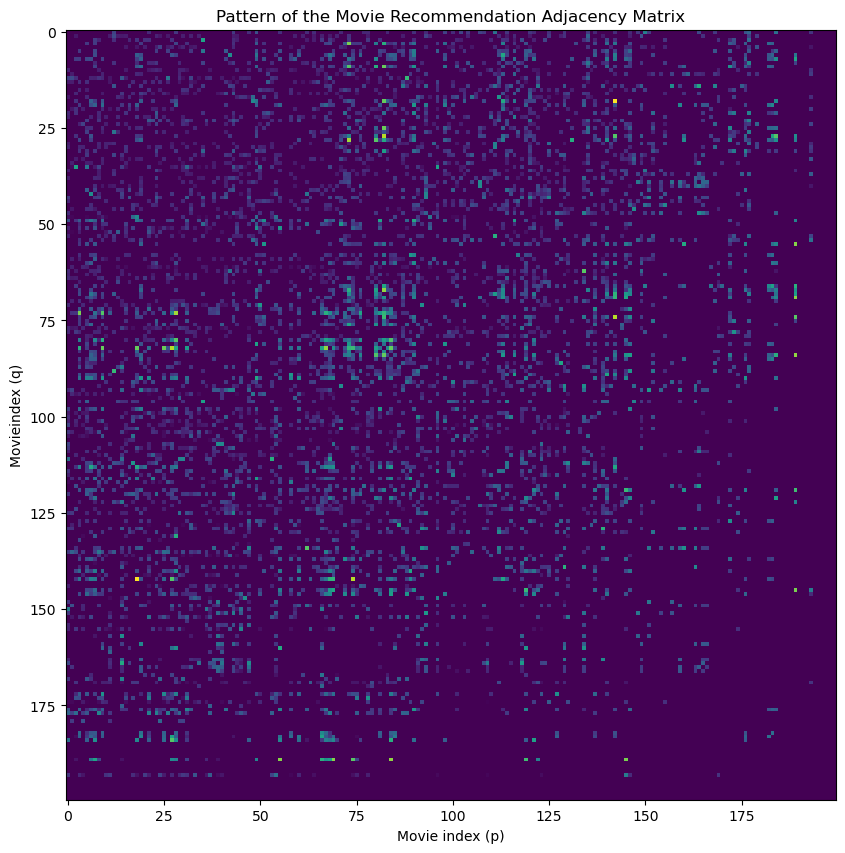

In [8]:
plt.figure(1, figsize=(12, 10))
plt.title('Pattern of the Movie Recommendation Adjacency Matrix')
plt.xlabel('Movie index (p)')
plt.ylabel('Movieindex (q)')
plt.imshow(S.numpy())   # S is a PyTorch tensor and needs to be converted to a NumPy array for visualization


## Mean Squared Error for Training and Testing

We would like to learn a vector-values function $\hat{\mathbf{y}}_i((S,\mathbf{x}_{i}); \mathcal{W})$ such that the $j$-th entry $[\hat{\mathbf{y}}_i]_m$  makes a rating predictions of movie $m$ for individual $i$. The input vector $\mathbf{x}_{i}$ contains all the available ratings for individual $i$. We will we  evaluate the quality of our prediction for the rating of movie $m$ from individual $i$ using the squared loss:

\begin{align}
   \ell \big([\hat{\mathbf{y}}_i]_m; \mathcal{W}), y_{im} \big)
      ~=~ \frac{1}{2}
               \Big[ \big([\hat{\mathbf{y}}_i]_m \big) - y_{im} \Big]^2
\end{align}

where $y_{im}$ is the actual rating that invidivual $i$ gave to movie $m$. We remark that the fact that the vector $\hat{\mathbf{y}}_i$ makes predictions for all movies is important during operation. The idea of the recommendation system is to identify the subset of products that the customer would rate highly. They are the ones that we will recommend. This is why we want a system that has a graph signal as an output even though the available dataset has scalar outputs.


In [10]:
# Movie MSE loss function. The inputs are: 
#
#    yHat: A set of rating estimates. It includes estimates of all movies.
#    y: A specific rating of a specific movie
#    p: The index of the movie whose rating is given by y
#
# This function evaluates the square of comparing yHat(p) with y. The function 
# is overloaded to accept as an input tensors with multiple movie ratings. If
# given multiple movie ratings it computes the mean squared error (the error
# averaged over the dataset)
# 
def movieMSELoss(yHat, y, idxMovie):
    
    # Isolate the predictions in yHat (a tensor containing estimated ratings for all movies) that we will use for comparison.
    #
    prediction = yHat[range(yHat.shape[0]),:,idxMovie.numpy()].squeeze()
    #
    #The three indexes used above, '[range(yHat.shape[0]),:,idxMovie.numpy()]', are used to correctly select the estimated ratings from yHat for the specific movies identified by idxMovie across all instances/users in the batch. The .squeeze() method is needed for dimension match between y and yHat.

    # Assign the actual ratings y to a variable truth
    truth = y
    
    # Evaluate squared error averaged over the dataset
    mse = nn.MSELoss()
    return mse(prediction, truth)


## Graph Filter

A parametrization that is convenient for processing graph signals is a graph convolutional filter. To define this operation introduce a filter order $K$ along with filter coefficients $\mathbf{H}_k$ (in NETS312, this is denoted by $\mathbf{W}_k$) that we group in the tensor $\mathcal{H}=[\mathbf{H}_0,\ldots, \mathbf{H}_{K-1}]$ (equivalent to $\mathcal{W}$ in NETS312).

\begin{equation}
\mathbf{\Phi}((\mathbf{S},\mathbf{X}); \mathcal{H} ) = \sum_{k=0}^{K} \mathbf{S}^k \mathbf{X}\, \mathbf{H}_k
\end{equation}

where the output $\mathbf{\Phi}$ is also a graph signal and the learnable parameters $\mathcal{H}$ are the kernel coefficients $\mathbf{H}_k$.

Given the kernel coefficients, the graph operator and the input graph signal, we can then implement a torch.nn.Module class to compute $\mathbf{\Phi}$.


In [ ]:
class GraphFilter(nn.Module):
    #First we initialize the graph filter class and define the attributes
    def __init__(self, gso, k, f_in, f_out, bias): # __init__ is a special method, called constructor, that 'initializes' a newly created objects of this class 
        super().__init__() # initializes the base class (nn.Module), enabling the module to work correctly within PyTorch
        self.gso = torch.tensor(gso) # Stores the graph operator (the CosSim matrix) as a 'torch.Tensor' from the module 'torch'
        self.n = gso.shape[0] # number of nodes
        self.k = k # kernel length
        self.f_in = f_in # feature dimension of the input signal
        self.f_out = f_out # feature dimension of the output signal
        if bias: # If 'bias'='True'
            self.bias = nn.parameter.Parameter(torch.Tensor(self.f_out, 1)) # The 'Parameter' class is defined in a sub-module named 'parameter' within the 'nn' module. This line indicates the tensor 'torch.Tensor(self.f_out, 1)' is a trainable parameter.
        self.weight = nn.Parameter(torch.randn(self.f_out, self.k, self.f_in)) # This line initializea a trainable 3rd-order random tensor of the dimensions indicated
        self.reset_parameters() # This is a method to initialize weight and bias
        
    def reset_parameters(self): # Define the method 'reset_parameters' that initializes weight and bias
        stdv = 1. / math.sqrt(self.f_in * self.k) # Common heuristic to randomly initialize the values of the trainable weight tensor in order to achieve faster convergence.
        torch.nn.init.uniform_(self.weight, -stdv, stdv) # '.data' gives access to the underlying raw tensor of a parameter and '.uniform_' fills the tensor with random entries. The underscore indicates that this operation is in-place, meaning it directly modifies the data of the tensor it is called on, rather than creating a new tensor.
        
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -stdv, stdv) # Same as above...
    
    def FilterFunction(self, x):
        S = self.gso # graph shift operator
        h = self.weight # trainable parameters
        F = h.shape[0] # feature dimension of the output signal
        G = h.shape[2] # feature dimension of the input signal
        B = x.shape[0] # batch size

        x = x.reshape([B, 1, G, self.n])
        S = S.reshape([1, self.n, self.n])
        z = x
        # The following for-loop is utilized to perform the graph diffusions
        for k in range(1, self.k):
            x = torch.matmul(x, S)
            xS = x.reshape([B, 1, G, self.n])
            z = torch.cat((z, xS), dim=1)
        y = torch.matmul(z.permute(0, 3, 1, 2).reshape([B, self.n, self.k*G]), h.reshape([F, self.k*G]).permute(1, 0)).permute(0, 2, 1) # batchsize x output features x number of nodes
        
        # we add bias to the linear operation
        if self.bias is not None:
            y = y + self.bias # y: out x 1
        return y

    def forward(self, x):
        return self.FilterFunction(x)
    


## Graph Neural Network

Graph neural networks (GNNs) extend graph filters by using pointwise nonlinearities which are nonlinear functions that are applied independently to each component of a vector. For a formal definition, begin by introducing a single variable function $\sigma:\mathbb{R}\to\mathbb{R}$ which we extend to the matrix function $\sigma:\mathbb{R}^{n\times q}\to\mathbb{R}^{n\times q}$ by independent application to each component. Thus, if we have $\mathbf{U} \in \mathbb{R}^{n\times q}$ the output matrix $\sigma(\mathbf{U})$ is such that

\begin{equation}
\sigma\big(\,\mathbf{U}\,\big) \ : \ \big[\,\sigma\big(\,\mathbf{U}\,\big)\,\big]_{i,j} = \sigma\big(\,\mathbf{U}_{i,j}\,\big).
\end{equation}

In a single layer GNN, the graph signal $\mathbf{U} = \sum_{k=0}^{K-1} \mathbf{U}_k \mathbf{H}_k$ is passed through a pointwise nonlinear function to produce the output

\begin{equation}
\mathbf{\Phi}(\mathbf{X};\mathcal{H}, \mathbf{S}) = \sigma(\mathbf{U}) = \sigma \left( \sum_{k=0}^{K-1} \mathbf{S}^k \mathbf{X} \mathbf{H}_k \right) \ .
\end{equation}

We say that the transform above is a graph perceptron. Different from the graph filter, the graph perceptron is a nonlinear function of the input. It is, however, a very simple form of nonlinear processing because the nonlinearity does not mix signal components. Signal components are mixed by the graph filter but are then processed element-wise through $\sigma$.


### Multi-layer GNN

Graph perceptrons can be stacked in layers to create multi-layer GNNs. This stacking is mathematically written as a function composition where the outputs of a layer become inputs to the next layer. For a formal definition let $l=1,\ldots,L$ be a layer index and $\mathbf{H}_l=\{H_{l k}\}_{k=0}^{K-1}$ be collections of $K$ graph filter coefficients associated with each layer. At layer $l$ we take as input the output $\mathbf{X}_{l-1}$ of layer $l-1$ which we process with the filter $\mathbf{\Phi} (\mathbf{C}; \mathcal{H}_l, \mathbf{S})$ to produce the intermediate feature

\begin{align}
\mathbf{U}_{l} \ = \ \sum_{k=0}^{K-1} \mathbf{S}^k\, \mathbf{X}_{l-1} \mathbf{H}_{l k},
\end{align}

where, by convention, we say that $\mathbf{X}_0 = \mathbf{X}$ so that the given graph signal $\mathbf{X}$ is the GNN input. As in the case of the graph perceptron, this feature is passed through a pointwise nonlinear function to produce the $l$th layer output

\begin{align}
\mathbf{X}_{l} \ = \ \sigma(\mathbf{U}_l )
\ = \ \sigma\Bigg(\sum_{k=0}^{K-1} \mathbf{S}^k\, \mathbf{X}_{l-1} \mathbf{H}_{l k}\Bigg) .
\end{align}

After recursive repetition of the above formula for $l=1,\ldots,L$ we reach the $L$th layer whose output $\mathbf{x}_L$ is not further processed and is declared the GNN output $\mathbf{y}=\mathbf{x}_L$. To represent the output of the GNN we define the filter tensor $\mathcal{H}:=\{\mathcal{H}_l\}_{l=1}^L$ grouping the $L$ tensors of filter coefficients at each layer, and define the operator $\mathbf{\Phi}(\,\cdot\,;\mathcal{H},\mathbf{S})$ as the map

\begin{align}
\mathbf{\Phi} (\mathbf{X}; \mathcal{H}, \mathbf{S}) = \mathbf{X}_L.
\end{align}

In PyTorch, a multi-layer GNN can be built using a torch.nn.Module that takes in the GSO, the number of layers, the number of filter taps in each layer and the nonlinearity and instantiates as many perceptrons as there are layers:


In [6]:

class GNN(nn.Module):
    def __init__(self, gso, l, k, f, sigma, bias):
        super().__init__()
        self.gso = torch.tensor(gso) # the graph shift operator (weighted adjacency matrix)
        self.n = gso.shape[0] # number of nodes
        self.l = l # number of layers in the GNN
        self.k = k # number of filter taps
        self.f = f # feature dimension of each layer
        self.sigma = sigma # pointwise nonlinearity
        self.bias = bias
        # we create a series of graph filters followed by pointwise nonlinear functions
        gml = []
        for layer in range(l-1):
            gml.append(GraphFilter(gso,k[layer],f[layer],f[layer+1], bias))
            gml.append(sigma)
        gml.append(GraphFilter(gso,1,f[layer+1],f[layer+2], bias))
        
        self.gml = nn.Sequential(*gml)
        
    def forward(self, x):
        return self.gml(x)
    


Next we create objects for the different architectures.


In [7]:

architectures = dict()

# # Graph filter
graphFilter = nn.Sequential(GraphFilter(S,5,1,64,True), GraphFilter(S,1,64,1,True))
architectures['GraphFilter'] = graphFilter


# GNN
GNN2Ly = GNN(S,3,[5,5,1],[1,64,32,1],nn.ReLU(),True)
architectures['GNN 2 layer'] = GNN2Ly


/var/folders/kf/bs96cm9123zg5spqhm4jmwh40000gn/T/ipykernel_40237/1442950351.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gso = torch.tensor(gso) # the graph shift operator (weighted adjacency matrix)
/var/folders/kf/bs96cm9123zg5spqhm4jmwh40000gn/T/ipykernel_40237/823052750.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gso = torch.tensor(gso) # the graph shift operator (weighted adjacency matrix)



## The training loop

We define the training parameters and specify the optimization methods for all the architectures.


In [8]:

nEpochs = 100
batchSize = 10
learningRate = 0.01

# Declaring the optimizers for each architectures
optimizers = dict()
for key in architectures.keys():
    optimizers[key] = optim.Adam(architectures[key].parameters(), lr=learningRate)
    


We are almost ready for the training loop!


In [9]:

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

# Store the training...
costTrain = dict()
lossTestLast = dict()
costTestLast = dict()

bestModel = dict()

for key in architectures.keys():
    costTrain[key] = []
    


The following defines the training loop.


In [10]:

epoch = 0 # epoch counter
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:,:]
        yTrainBatch = yTrain[thisBatchIndices]
        pTrainBatch = pTrain[thisBatchIndices]
        
        for key in architectures.keys():
            # Reset gradients
            architectures[key].zero_grad()

            # Obtain the output of the architectures
            yHatTrainBatch = architectures[key](xTrainBatch)

            # Compute loss
            lossValueTrain = movieMSELoss(yHatTrainBatch, yTrainBatch, pTrainBatch)
        
            # Compute gradients
            lossValueTrain.backward()
        
            # Optimize
            optimizers[key].step()

        batch+=1
        
    for key in architectures.keys():
        # Reset gradients
        architectures[key].zero_grad()

        # Obtain the output of the architectures
        yHatTrain = architectures[key](xTrain)

        # Compute loss
        costTrain[key] += [np.sqrt(movieMSELoss(yHatTrain, yTrain, pTrain).item())]
             
    epoch+=1
    


Epoch 1

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19

Epoch 20

Epoch 21

Epoch 22

Epoch 23

Epoch 24

Epoch 25

Epoch 26

Epoch 27

Epoch 28

Epoch 29

Epoch 30

Epoch 31

Epoch 32

Epoch 33

Epoch 34

Epoch 35

Epoch 36

Epoch 37

Epoch 38

Epoch 39

Epoch 40

Epoch 41

Epoch 42

Epoch 43

Epoch 44

Epoch 45

Epoch 46

Epoch 47

Epoch 48

Epoch 49

Epoch 50

Epoch 51

Epoch 52

Epoch 53

Epoch 54

Epoch 55

Epoch 56

Epoch 57

Epoch 58

Epoch 59

Epoch 60

Epoch 61

Epoch 62

Epoch 63

Epoch 64

Epoch 65

Epoch 66

Epoch 67

Epoch 68

Epoch 69

Epoch 70

Epoch 71

Epoch 72

Epoch 73

Epoch 74

Epoch 75

Epoch 76

Epoch 77

Epoch 78

Epoch 79

Epoch 80

Epoch 81

Epoch 82

Epoch 83

Epoch 84

Epoch 85

Epoch 86

Epoch 87

Epoch 88

Epoch 89

Epoch 90

Epoch 91

Epoch 92

Epoch 93

Epoch 94

Epoch 95

Epoch 96

Epoch 97

Epoch 98

Epoch 99

Epoch 100



## Training error evolution
We plot the training cost after every epoch for the 2-layer GNN:


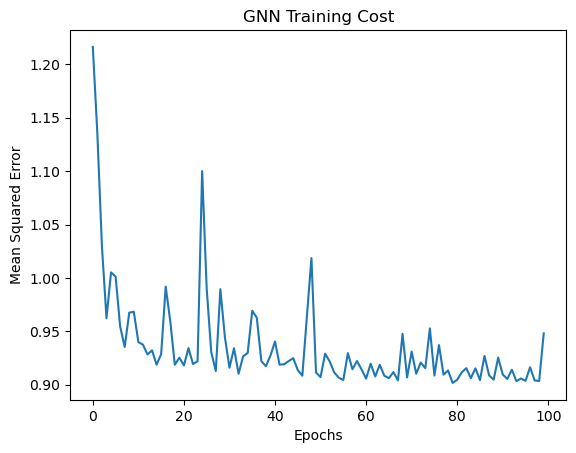

In [11]:

plt.figure(2)
plt.plot(costTrain['GNN 2 layer'])
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.title('GNN Training Cost')
plt.show()



## Evaluation

We evaluate the testing accuracy for the four different models.


In [12]:

print("Final evaluation results")

for key in architectures.keys():
    with torch.no_grad():
        yHatTest = architectures[key](xTest)
    lossTestLast[key] = movieMSELoss(yHatTest, yTest, pTest)
    costTestLast[key] = np.sqrt(lossTestLast[key].item())
    
    print(" " + key +  " %6.4f [Last]" % (
                        costTestLast[key]))
    

Final evaluation results
 GraphFilter 0.9922 [Last]
 GNN 2 layer 0.9404 [Last]
